In [1]:
from Alice_Macros import *
from statsmodels.stats.multitest import multipletests
import matplotlib.pylab as plt
from TreeOperations import PhyFisher
from TreeOperations import GetPhyloContingency
from rpy2 import robjects
import numpy as np
from numpy.random import binomial
from scipy import sparse as sp
from scipy.stats import binom, poisson, rv_discrete
from scipy.stats.distributions import hypergeom, norm
import os
import bisect
import tqdm
import pickle 
import sys
import ete3
import tqdm
import itertools

In [60]:
# https://stats.stackexchange.com/questions/52646/variance-of-product-of-multiple-random-variables
# https://mathoverflow.net/questions/121411/expectation-of-square-root-of-binomial-r-v
def my_norm(rate_a, rate_b):
    expected_var = (rate_a * rate_b)
    expected_std = np.sqrt(expected_var) * np.sqrt(population)
    return norm(0, expected_std)

def my_pois(rate_a, rate_b, upper_lim):
    lam = .5*rate_a*rate_b*population # supposed to be .5
    pvals = np.array([sum((poisson(lam).pmf(k+i)*poisson(lam).pmf(i)) for i in range(upper_lim)) 
                      for k in range(upper_lim)])
    # this is for one sided, for two sided by symetry:
    pvals[1:] *= 2
    pvals_sf = dict(zip(range(upper_lim), np.concatenate([[0], np.cumsum(pvals[::-1])])[::-1]))
    pois_tail = np.vectorize(lambda x: pvals_sf[bisect.bisect_left(range(upper_lim), x)])
    return pois_tail

def my_direct_pois_pval(rates_a, rate_b, scores, upper_lim):
    rates_a, inver = np.unique(rates_a, return_inverse=True)
    lams = .5*rates_a*rate_b*population # supposed to be .5
    res = []
    for lam in tqdm.tqdm(lams, total=len(lams), desc='individual pvals...'): 
        pvals = np.array([sum((poisson(lam).pmf(k+i)*poisson(lam).pmf(i)) for i in range(upper_lim)) 
                          for k in range(upper_lim)])
        # this is for one sided, for two sided by symetry:
        pvals[1:] *= 2
        pvals_sf = np.concatenate([[0], np.cumsum(pvals[::-1])])[::-1]
        res.append(pvals_sf)
    res = np.array(res)
    return res.take(inver*res.shape[1] + scores)

def my_direct(rate_a, rate_b):
    tot_rate = rate_a*rate_b
    x_ = [.5*tot_rate, 1-tot_rate, .5*tot_rate]
    x = x_
    for _ in range(population):
        x = np.convolve(x,x_)
    z_ = np.argmax(x)
    x = x[z_:]
    x[1:] *= 2
    pvals_sf = dict(zip(range(len(x)), np.concatenate([[0], np.cumsum(x[::-1])])[::-1]))
    tail = np.vectorize(lambda y: pvals_sf[bisect.bisect_left(range(len(pvals_sf)), y)])
    return tail

def my_direct_pval(rates_a, rate_b, scores):
    rates_a, inver = np.unique(rates_a, return_inverse=True)
    p = rates_a*rate_b
    p = np.vstack([.5*p, 1-p, .5*p]).T

    res = []
    for x_ in tqdm.tqdm(p, total=len(p), desc='individual pvals...'): 
        i = 1
        x = x_
        while i**2 < population:
            x = np.convolve(x,x)
            i *=2
        while i < population:
            x = np.convolve(x,x_)
            i +=1
        z_ = np.argmax(x)
        x = x[z_:]
        x[1:] *= 2
        x = np.cumsum(x[::-1])[::-1]
        res.append(x)
    res = np.array(res)
    return res.take((inver*res.shape[1] + scores))

In [2]:
def left_tail_(samples):
    val, count= np.unique(samples, return_counts=True)
    count = count/len(samples)
    pval_sf_list = np.concatenate([[0], np.cumsum(count)])
    pval = np.vectorize(lambda x: pval_sf_list[bisect.bisect_right(val, x)])
    return pval

In [3]:
def right_tail_(samples):
    val, count= np.unique(samples, return_counts=True)
    count = count/len(samples)
    pval_sf_list = np.concatenate([[0], np.cumsum(count[::-1])])[::-1]
    pval = np.vectorize(lambda x: pval_sf_list[bisect.bisect_left(val, x)])
    return pval

In [4]:
def GenerateTree(ntax, birth_rate, death_rate, SaveDir = None):
    t = ete3.Tree(robjects.r("ape::write.tree(ape::rphylo({},{},{},fossils=FALSE))".format(ntax,birth_rate,death_rate))[0])
    for i, node in enumerate(t.traverse()): node.name = str(i)
    if SaveDir:
        if not os.path.exists(SaveDir): os.mkdir(SaveDir)
        pickle.dump(t, open(os.path.join(SaveDir, "tree"), 'wb'))
    return t

In [5]:
def events_to_contingency(events_per_mut):
    tables = []
    row_it = iter(events_per_mut)
    phen = set(next(row_it))
    for gene in tqdm.tqdm(row_it, total=len(events_per_mut)-1, desc='converting events to tables'):
        gene = set(gene)
        tables.append([population - len(set.union(phen, gene)),
                       len(set.difference(phen, gene)),
                       len(set.difference(gene, phen)),
                       len(set.intersection(gene, phen))])
    return tables

In [6]:
node_to_arr = lambda n: np.array(n.todense().astype(np.int8))[0]
def RandomAtributes(tree, population, n_genes, mut_func):
    # set binary atributes across phylogeny
    order = tree.traverse('preorder')
    root = next(order)
    root.genotype = sp.csr_matrix(np.random.randint(2, size=n_genes))
    for node in tqdm.tqdm(order, total=population, desc='propageting events on tree'):
        mut_here = mut_func()
        #node.genotype = sp.csr_matrix(np.abs(node_to_arr(node.up.genotype) - mut_here))
        node.genotype = np.abs(node.up.genotype - sp.csr_matrix(mut_here))
    return tree

In [7]:
def MarginalMaxLiklihood(X, Tree, tip_row_dict, do_tips=False, naming=False, m_rate=0.5):
    # 2 represents {0,1} set
    sp_to_arr = lambda sp_arr: np.array(sp_arr.todense().astype(np.int8))[0]
    wrap = lambda x: sp_to_arr(X[tip_row_dict[x.name]]) if x.is_leaf() and not do_tips else sp_to_arr(x.genotype)
    tree_len = 0
    for _ in Tree.traverse(): tree_len += 1
    for i, node in tqdm.tqdm(enumerate(Tree.traverse('postorder')), total=tree_len, desc='Ancestral Reconstruction: 1st pass'):
        if node.is_leaf():
            if not do_tips:
                node.genotype = X[tip_row_dict[node.name]]
            node.zero_prob = sp.csr_matrix(node.genotype == 0)
            node.one_prob = sp.csr_matrix(node.genotype == 1)
            continue
        if naming: node.name = i
        node.one_prob = ((node.children[0].zero_prob * m_rate) + (node.children[0].one_prob * (1-m_rate))) + ((node.children[1].zero_prob * m_rate) + (node.children[1].one_prob * (1-m_rate)))
        node.zero_prob= ((node.children[0].zero_prob * (1-m_rate)) + (node.children[0].one_prob * m_rate)) + ((node.children[1].zero_prob * (1-m_rate)) + (node.children[1].one_prob * m_rate))
        root.genotype = (root.zero_prob < root.one_prob).astype(int)

In [8]:
def JointMaxLiklihood(X, Tree, tip_row_dict, do_tips=False, naming=False, m_rate=0.5):
    # As explained in FastML
    # 2 represents {0,1} set
    sp_to_arr = lambda sp_arr: np.array(sp_arr.todense().astype(np.int8))[0]
    wrap = lambda x: sp_to_arr(X[tip_row_dict[x.name]]) if x.is_leaf() and not do_tips else sp_to_arr(x.genotype)
    tree_len = 0
    for _ in Tree.traverse(): tree_len += 1
    for node in tqdm.tqdm(Tree.traverse('postorder'), total=tree_len, desc='Ancestral Reconstruction: 1st pass'):
        if node.is_leaf():
            """
            For each OTU y perform the following:
            1a. Let j be the amino acid at y. Set, for each amino acid i: Cy(i)= j. 
                This implies that no matter what is the amino acid in the father of y, j is assigned to node y.
            1b. Set for each amino acid i: Ly(i) = Pij(ty), where ty is the branch length between y and its father.
            """
            if not do_tips:
                node.genotype = X[tip_row_dict[node.name]]
            node.C_0 = node.genotype
            node.C_1 = node.genotype
            node.L_0 = np.ones((node.genotype).shape[1]) * (1 - m_rate)
            node.L_0[node.genotype.indices] = m_rate           
            node.L_1 = np.ones((node.genotype).shape[1]) * m_rate
            node.L_1[node.genotype.indices] = (1-m_rate)
            
            # log
            node.L_1 = np.log(node.L_1)
            node.L_0 = np.log(node.L_0)
            continue
        
        """
        Visit a nonroot internal node, z, which has not been visited yet, 
        but both of whose sons, nodes x and y, have already been visited, 
        i.e., Lx(j), Cx(j), Ly(j), and Cy(j) have already been defined for each j. 
        Let tz be the length of the branch connecting node z and its father. 
        For each amino acid i, compute Lz(i) and Cz(i) according to the following formulae:

        2a. Lz(i) = maxj Pij(tz)× Lx(j) × Ly(j).
        2b. Cz(i) = the value of j attaining the above maximum.
        """
        #s0 = node.children[0].L_0.multiply(node.children[1].L_0)
        #s0 = node.children[0].L_0 * node.children[1].L_0
        s0 = node.children[0].L_0 + node.children[1].L_0
        s1 = node.children[0].L_1 + node.children[1].L_1
        
        # L0_0 = (1-m_rate) * s0
        # L0_1 = m_rate * s1
        L0_0 = np.log(1-m_rate) + s0
        L0_1 = np.log(m_rate) + s1
        # node.L_0 = L0_0.maximum(L0_1) # should be ever expanding right?
        node.L_0 = np.maximum(L0_0, L0_1)
        node.C_0 = L0_0 < L0_1
        
        #L1_0 = m_rate * s0
        #L1_1 = (1-m_rate) * s1
        L1_0 = np.log(m_rate) + s0
        L1_1 = np.log(1-m_rate) + s1
        #node.L_1 = L1_0.maximum(L1_1)
        node.L_1 = np.maximum(L1_0, L1_1)
        node.C_1 = L1_0 < L1_1
        
       
        del node.children[0].L_0
        del node.children[1].L_0
        del node.children[0].L_1
        del node.children[1].L_1
       
    #return Tree
    
    post = Tree.traverse('preorder')
    root = next(post)
    """
    Denote the sons of the root by x, y. 
    For each amino acid k, compute the expression Pk × Lx(k) × Ly(k). 
    Reconstruct r by choosing the amino acid k maximizing this expression. 
    The maximum value found is the likelihood of the best reconstruction.
    """
    root.genotype = sp.csr_matrix(root.L_0 < node.L_1)
    if naming: root.name = 0
    for i,node in tqdm.tqdm(enumerate(post), total=tree_len, desc='Ancestral Reconstruction: 2nd pass'):
        """
        Traverse the tree from the root in the direction of the OTUs, 
        assigning to each node its most likely ancestral character as follows:
        
        5a. Visit an unreconstructed internal node x whose father y has already been reconstructed. 
            Denote by i the reconstructed amino acid at node y.
        5b. Reconstruct node x by choosing Cx(i).
        5c. Return to step 5a until all internal nodes have already been reconstructed.
        """
        if not node.is_leaf(): 
            if naming: node.name = i + 1
            node.genotype = sp.csr_matrix(node.C_0)
            node.genotype[0, node.up.genotype.indices] = node.C_1[node.up.genotype.indices]
            # np.where(node.up.genotype, node.C_1, node.C_0)
        del node.C_0,node.C_1
    
    return Tree 

In [9]:
def MaxParsimonyNoTable(X, Tree, tip_row_dict, do_tips=False, naming=False):
    """
    Reconstruct ancestral characters using MaxParsimony / occam's razor logic...
    Note this implementation relays on binary characters

    The first pass extracts info from the leaves upwards with the following function:
    Intersect when an intersection is available, otherwise yeild union.
    e.g given dijointed sets A,B

         AUB   |      A     |      B
         /^\   |     /^\    |     /^\
        A  B   |    A  AUB  |    B  B

    The second pass brings stable information from root to leaves.
    The root might need randomization to deside on a character.
    We consider events influenced by randomization as risky, and they are documented in 'random'.
    A parent will always be a single character, and a son might get updated by intersection with parent node:

         A     >      A     |     A     >      A     |
        /^\    >     /^\    |    /^\    >     /^\    |
       A  AUB  >    A  A    |   A  B    >    A   B    |

    :param X: sparse csr_mat data to reconstruct
    :param Tree: ete3 tree
    :param tip_row_dict: dict mapping leaf names to row number in X
    :return: A tree where each node has a
            .genotype containing the reconstruction by X
            .random documenting non-determinant values
    """
    # 2 represents {0,1} set
    sp_to_arr = lambda sp_arr: np.array(sp_arr.todense().astype(np.int8))[0]
    wrap = lambda x: sp_to_arr(X[tip_row_dict[x.name]]) if x.is_leaf() and not do_tips else sp_to_arr(x.genotype)
    tree_len = 0
    for _ in Tree.traverse(): tree_len += 1
    for i, node in tqdm.tqdm(enumerate(Tree.traverse('postorder')), total=tree_len, desc='Ancestral Reconstruction: 1st pass'):
        if node.is_leaf():
            if not do_tips:
                node.genotype = X[tip_row_dict[node.name]]
            continue
        if naming: node.name = i
        children = [wrap(c) for c in node.children]
        res = children[0].copy()
        eq = np.equal(*children)
        res[children[0] == 2] = children[1][children[0] == 2]  # 2 is the union {0,1}
        res[children[1] == 2] = children[0][children[1] == 2]
        res[(children[0] != 2) & (children[1] != 2) & ~eq] = 2
        node.genotype = sp.csr_matrix(res)

    post = Tree.traverse('preorder')
    root = next(post)
    root.random = (wrap(root) == 2)
    root.genotype[root.genotype == 2] = np.random.choice([1, 0], size=(root.genotype == 2).sum())
    for node in tqdm.tqdm(post, total=tree_len - 1, desc='Ancestral Reconstruction: 2nd pass'):
        if node.is_leaf(): continue
        parent_ = wrap(node.up)
        node_ = wrap(node)
        res = node_.copy()
        res[node_ == 2] = parent_[node_ == 2]
        node.random = (node.up.random) & (node_ == 2)  # these are unstable positions - will not be counted
        node.genotype = sp.csr_matrix(res)

    return Tree

In [10]:
def GetPhyloTipsContingency(tree, phenotree, phen_ind, skip=0):
    """
    Collects co-occuring events along the phylogeny
    
                                 /--(1,1)
                       /--(0,1)-|
             /--(0,1)-|          \--(0,1)
    --(0,1)-|          \--(1,1)
             \--(0,1)

    Would translate to the following contingency table:

    T\Q| 0  1
    ---------
     0 | 4  1
     1 | 1  0

    :param tree: ete3 tree
    :param phen_ind: index of target T
    :param skip: number of qualities to skip
    :return: A contingency table for each available quality in a nodes 'genotype' value
    # TODO someday, if there are too much kmers build upo ad 3d hist, adding binary 3d objects one node at a time.
    """

    hist_kmers = []
    node_to_arr = lambda n: np.array(n.genotype.todense().astype(np.int8))[0]
    for leaf, phen_leaf in tqdm.tqdm(zip(tree, phenotree), 
                                         total=len(tree), desc='Iterating leaves'):
        
        gene_state = node_to_arr(leaf)[skip:]
        phen_state = np.int8(phen_leaf.genotype[0, phen_ind])
        
        hist = 2 * phen_state + gene_state  # current state
        hist_kmers.append(hist)
            
    bins = lambda x: np.bincount(x[x >= 0], minlength=4)
    contingencies = np.apply_along_axis(bins, 0, hist_kmers)
    return contingencies

In [11]:
def GetPhyloSebsequentScore(tree, phenotree, phen_ind, skip=0, with_rand=False, dist_only=False, dist=None):
    """
    Collects co-occuring events along the phylogeny
    
                                 /--(1,1)
                       /--(0,1)-|
             /--(0,1)-|          \--(0,1)
    --(0,1)-|          \--(1,1)
             \--(0,1)

    Would translate to the following contingency table:

    T\Q| 0  1
    ---------
     0 | 4  1
     1 | 1  0

    :param tree: ete3 tree
    :param phen_ind: index of target T
    :param skip: number of qualities to skip
    :return: A contingency table for each available quality in a nodes 'genotype' value
    """

    subscore = np.zeros(tree.genotype.shape[1] - skip)
    node_to_arr = lambda n: np.array(n.genotype.todense().astype(np.int8))[0]
    for i, (cur_node, phen_node) in tqdm.tqdm(enumerate(zip(tree.traverse(), phenotree.traverse())), 
                                         total=population+1, desc='Iterating tree'):        
        if not cur_node.is_root():
            if not cur_node.is_leaf() and with_rand and cur_node.random[phen_ind]: continue
            node = node_to_arr(cur_node)
            prev_node = node_to_arr(cur_node.up)
            
            gene_state = node[skip:]
            prev_gene_state = prev_node[skip:]
            
            phen_state = phen_node.genotype[0, phen_ind]
            prev_phen_state = phen_node.up.genotype[0, phen_ind]
            
            subscore += np.abs((1.333 * prev_phen_state * prev_gene_state) + 
                              (.666 * prev_phen_state * gene_state) + 
                              (.666 * phen_state * prev_gene_state) + 
                              (1.333 * phen_state * gene_state) - 
                              phen_state - 
                              prev_phen_state - 
                              gene_state - 
                              prev_gene_state + 
                              1)
           
    if dist_only:
        hist_ = np.histogram(subscore, bins=int(1e7))
        fit_dist = rv_histogram(hist_)
        fit_dist.bin = np.diff(hist_[1]).max()
        return fit_dist
    if dist is not None:
        return dist.sf(subscore)
    else:
        return subscore

In [12]:
def GetPhyloParallelScore(tree, phenotree, phen_ind, skip=0, with_rand=False):
    """
    Collects co-occuring events along the phylogeny
    
                                 /--(1,1)
                       /--(0,1)-|
             /--(0,1)-|          \--(0,1)
    --(0,1)-|          \--(1,1)
             \--(0,1)

    Would translate to the following contingency table:

    T\Q| 0  1
    ---------
     0 | 4  1
     1 | 1  0

    :param tree: ete3 tree
    :param phen_ind: index of target T
    :param skip: number of qualities to skip
    :return: A contingency table for each available quality in a nodes 'genotype' value
    """

    score = np.zeros(tree.genotype.shape[1] - skip)
    node_to_arr = lambda n: np.array(n.genotype.todense().astype(np.int8))[0]
    contingency_sum = 100
    for i, (cur_node, phen_node) in tqdm.tqdm(enumerate(zip(tree.traverse(), phenotree.traverse())), 
                                         total=population+1, desc='Iterating tree'):
        if not cur_node.is_root():
            if not cur_node.is_leaf() and with_rand and cur_node.random[phen_ind]: continue
            node = node_to_arr(cur_node)
            prev_node = node_to_arr(cur_node.up)
            
            gene_state = node[skip:]
            prev_gene_state = prev_node[skip:]
            
            phen_state = phen_node.genotype[0, phen_ind]
            prev_phen_state = phen_node.up.genotype[0, phen_ind]
            
            phen_event = (prev_phen_state - phen_state)
            gene_event = (prev_gene_state - gene_state)
            
            if with_rand: gene_event[cur_node.up.random[skip:]] = 0
            score += phen_event * gene_event
            
    return score.astype(np.int)

In [13]:
def GetPhyloParalelContingency(tree, phenotree, phen_ind, skip=0, with_rand=False):
    """
    Collects co-occuring events along the phylogeny
    
                                 /--(1,1)
                       /--(0,1)-|
             /--(0,1)-|          \--(0,1)
    --(0,1)-|          \--(1,1)
             \--(0,1)

    Would translate to the following contingency table:

    T\Q| 0  1
    ---------
     0 | 4  1
     1 | 1  0

    :param tree: ete3 tree
    :param phen_ind: index of target T
    :param skip: number of qualities to skip
    :return: A contingency table for each available quality in a nodes 'genotype' value
    """

    hist_kmers = []
    node_to_arr = lambda n: np.array(n.genotype.todense().astype(np.int8))[0]
    contingency_sum = 100
    contingencies = None
    for i, (cur_node, phen_node) in tqdm.tqdm(enumerate(zip(tree.traverse(), phenotree.traverse())), 
                                         total=population+1, desc='Iterating tree'):
        if (i+1) % contingency_sum == 0 :
            # mem inefficiant here
            bins = lambda x: np.bincount(x[x >= 0].astype(np.int8), minlength=4)
            if hist_kmers:
                if contingencies is None:
                    contingencies = np.apply_along_axis(bins, 0, np.array(hist_kmers).astype(np.int8))
                else:
                    contingencies += np.apply_along_axis(bins, 0, np.array(hist_kmers).astype(np.int8))
            hist_kmers = []
            
        if not cur_node.is_root():
            if not cur_node.is_leaf() and with_rand and cur_node.random[phen_ind]: continue
            node = node_to_arr(cur_node)
            prev_node = node_to_arr(cur_node.up)
            
            gene_state = node[skip:]
            prev_gene_state = prev_node[skip:]
            
            phen_state = phen_node.genotype[0, phen_ind]
            prev_phen_state = phen_node.up.genotype[0, phen_ind]
            
            phen_event = (prev_phen_state - phen_state) # +-1, 0
            gene_event = (prev_gene_state - gene_state) # +-1, 0     
            
            hist = gene_event.copy()
            if phen_event == 0:
                continue
            if phen_event == -1:
                hist[gene_event==-1] = 0
                hist[gene_event==1] = 2
                hist[gene_event==0] = -1
            if phen_event == 1:
                hist[gene_event==-1] = 1
                hist[gene_event==1] = 3
                hist[gene_event==0] = -1
            
            if with_rand: hist[cur_node.up.random[skip:]] = -1
            # mark non-deterministic transition as invalid
            if not cur_node.is_leaf() and with_rand: 
                hist[cur_node.random[skip:]] = -1
            hist_kmers.append(hist.astype(np.int8))
            
    bins = lambda x: np.bincount(x[x >= 0], minlength=4) # TODO mem inefficiant
    if contingencies is None:
        contingencies = np.apply_along_axis(bins, 0, hist_kmers)
    else:
        contingencies += np.apply_along_axis(bins, 0, hist_kmers) 
    return contingencies

In [14]:
def ParalelContingencyToScore(Tables):
    return (([1,-1, -1, 1]) * Tables.T).sum(axis=1).T

In [15]:
def GetPhyloEventContingency(tree, phenotree, phen_ind, skip=0, with_rand=False):
    """
    Collects co-occuring events along the phylogeny
    
                                 /--(1,1)
                       /--(0,1)-|
             /--(0,1)-|          \--(0,1)
    --(0,1)-|          \--(1,1)
             \--(0,1)

    Would translate to the following contingency table:

    T\Q| 0  1
    ---------
     0 | 4  1
     1 | 1  0

    :param tree: ete3 tree
    :param phen_ind: index of target T
    :param skip: number of qualities to skip
    :return: A contingency table for each available quality in a nodes 'genotype' value
    """

    hist_kmers = []
    node_to_arr = lambda n: np.array(n.genotype.todense().astype(np.int8))[0]
    contingency_sum = 100
    contingencies = None
    for i, (cur_node, phen_node) in tqdm.tqdm(enumerate(zip(tree.traverse(), phenotree.traverse())), 
                                         total=population+1, desc='Iterating tree'):
        if (i+1) % contingency_sum == 0 :
            # mem inefficiant here
            bins = lambda x: np.bincount(x[x >= 0].astype(np.int8), minlength=4)
            if hist_kmers:
                if contingencies is None:
                    contingencies = np.apply_along_axis(bins, 0, hist_kmers)
                else:
                    contingencies += np.apply_along_axis(bins, 0, hist_kmers)
            hist_kmers = []
            
        if not cur_node.is_root():
            if not cur_node.is_leaf() and with_rand and cur_node.random[phen_ind]: continue
            node = node_to_arr(cur_node)
            prev_node = node_to_arr(cur_node.up)
            
            gene_state = node[skip:]
            prev_gene_state = prev_node[skip:]
            
            phen_state = phen_node.genotype[0, phen_ind]
            prev_phen_state = phen_node.up.genotype[0, phen_ind]
            
            phen_event = (prev_phen_state != phen_state)
            gene_event = ~np.equal(prev_gene_state, gene_state)
            
            hist = 2 * phen_event + gene_event  # current state
            if with_rand: hist[cur_node.up.random[skip:]] = -1
            # mark non-deterministic transition as invalid
            if not cur_node.is_leaf() and with_rand: 
                hist[cur_node.random[skip:]] = -1
            hist_kmers.append(hist.astype(np.int8))
            
    bins = lambda x: np.bincount(x[x >= 0], minlength=4) # TODO mem inefficiant
    if contingencies is None:
        contingencies = np.apply_along_axis(bins, 0, hist_kmers)
    else:
        contingencies += np.apply_along_axis(bins, 0, hist_kmers) 
    return contingencies

In [16]:
def SetHomoplasy(tree, skip=0):
    """
    Get distribution of homoplasy
    """
    order = tree.traverse()
    root = next(order)
    homoplasy_hist = sp.csr_matrix(np.zeros(root.genotype.shape[1]-skip))
    for cur_node in tqdm.tqdm(order, total=population):
        homoplasy_hist += (cur_node.genotype[0, skip:] != cur_node.up.genotype[0, skip:])
    homoplasy_dist = pd.Series(homoplasy_hist.data).value_counts(normalize=True)
    fit_dist = rv_discrete(values=(homoplasy_dist.index.astype(int), homoplasy_dist.values.astype(float)))
    root.homoplasy = fit_dist
    root.homoplasy_hist =  homoplasy_hist.toarray()[0].astype(np.int)
    return tree

In [17]:
def score_to_pval(scores, pval_type='hist', right=True):
    colnames = ['pval', 'score']
    if type(pval_type) is rv_histogram:
        func = pval_type
        res = func(scores)
    elif 'hist' in pval_type:   
        func = right_tail_(scores) if right else left_tail_(scores)
        if 'hist_only' in pval_type : return func
        res = func(scores)
    res = pd.DataFrame(np.vstack([res, scores]).T, columns=colnames)
    return (res, func)

In [18]:
def my_para_pval(samples, std):
    # for diffrent std per position, let std be at length of samples
    my_norm = norm(0, std)
    #func = right_tail_(np.abs(my_norm.rvs(size=int(1e6))))
    #return func(np.abs(samples))
    return my_norm.sf(np.abs(samples/np.sqrt(population))) * 2

In [19]:
from scipy.stats import rv_histogram
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()
statspackage = importr('stats', robject_translations={'format_perc': '_format_perc'})

def tables_to_pval(tables, pval_type='fisher', twotail=False):
    colnames = ['ods', 'contingency']
    No_Phen_no_Kmer, Has_Kmer_no_Phen, Has_Phen_no_Kmer, Has_Kmer_and_Phen = tables

    # if ant zero's add 0.5 to all cells
    append = ~((No_Phen_no_Kmer > 0) * (Has_Kmer_no_Phen > 0) * (Has_Kmer_and_Phen > 0) * (
                Has_Phen_no_Kmer > 0)) * 0.5
    Has_Kmer_and_Phen = Has_Kmer_and_Phen + append
    Has_Kmer_no_Phen = Has_Kmer_no_Phen + append
    Has_Phen_no_Kmer = Has_Phen_no_Kmer + append
    No_Phen_no_Kmer = No_Phen_no_Kmer + append

    log_ods = np.log(np.divide((Has_Kmer_and_Phen * No_Phen_no_Kmer), (Has_Kmer_no_Phen * Has_Phen_no_Kmer)))
    
    if pval_type == 'fisher':
        print('calculating pvals')
        alt = 't' if twotail else 'g'
        fisher = np.vectorize(lambda x:  list(map(list, statspackage.fisher_test(x, alternative=alt)[:3])))
        fisher_input = list(zip(zip(Has_Kmer_and_Phen, Has_Kmer_no_Phen), zip(Has_Phen_no_Kmer, No_Phen_no_Kmer)))
        fisher_unique, curr_inverse_ind = np.unique(fisher_input, return_inverse=True, axis=0) #condence to uniq
        res = pd.DataFrame(fisher(pd.Series(list(fisher_unique))).tolist())[0].apply(lambda x: x[0])
        res = res.iloc[curr_inverse_ind].values
    elif pval_type == 'hist':     
        print('calculating pvals')
        hist_ = np.histogram(log_ods, bins=int(1e7))
        fit_dist = rv_histogram(hist_)
        fit_dist.bin = np.diff(hist_[1]).max()
        if twotail:
            #res = fit_dist.sf(np.abs(log_ods), loc=fit_dist.bin) + fit_dist.cdf(-np.abs(log_ods), loc=-fit_dist.bin)
            res = fit_dist.sf(np.abs(log_ods)) + fit_dist.cdf(-np.abs(log_ods))
        else:    
            res = fit_dist.sf(log_ods)#, loc=fit_dist.bin)
    elif pval_type == 'hist_only':
        print('calculating distribution')
        hist_ = np.histogram(-log_ods, bins=int(1e7))
        fit_dist = rv_histogram(hist_)
        fit_dist.bin = np.diff(hist_[1]).max()
        return fit_dist, pd.DataFrame([log_ods, tables.T], index=colnames).T
    elif type(pval_type) is rv_histogram:
        print('calculating pvals')
        if twotail:
            #res = pval_type.sf(np.abs(log_ods), loc=pval_type.bin) + pval_type.cdf(-np.abs(log_ods), loc=-pval_type.bin)
            res = pval_type.sf(-np.abs(log_ods)) + pval_type.cdf(np.abs(log_ods))
        else:
            res = pval_type.cdf(-log_ods)#, loc=pval_type.bin)
        pval_type = 'input_hist'
    return pd.DataFrame([res, log_ods, tables.T], index=['pval_'+pval_type]+colnames).T

In [20]:
from scipy.stats import pearsonr, spearmanr
def ods_fig(tot_tables, ods_columns):
    plt.close('all')
    with plt.style.context('default'):
        for col in ods_columns:
            plt.plot(sorted(tot_tables[col]), np.arange(len(tot_tables)) / len(tot_tables), label=col)
        plt.xlim(-6,6)
        # plt.xlabel(str(spearmanr(tot_tables['ods'], tot_tables['ods_recon'])))
        plt.legend()
        plt.title(str(n_mutations)+' mutations'+(' JointLike' if max_like else ' MaxPars')+': ods ratio cdf')
        if save_fig: plt.savefig(str(n_mutations)+('_max_like' if max_like else '')+'_ods.png')
        plt.show()

In [21]:
from scipy.stats import pearsonr, spearmanr
def ods_ratio_sf(tot_tables, ods_cols, outpath=''):
    plt.close('all')
    with plt.style.context('default'):
        for col in ods_cols:
            plt.plot(sorted(tot_tables[col], reverse=True), np.arange(len(tot_tables)) / len(tot_tables), label=col)
        plt.yscale('log')
        plt.xlabel(str(spearmanr(tot_tables[ods_cols[0]], tot_tables[ods_cols[1]])))
        plt.legend()
        plt.title(str(n_mutations)+' mutations'+(' JointLike' if max_like else ' MaxPars')+': ods ratio sf')

        if save_fig: plt.savefig(os.path.join(outpath, str(n_mutations)+('_max_like' if max_like else '')+'_ods.png'))
        plt.show()

In [77]:
def pval_hists(tables, pval_cols, cmap='rainbow', outpath=''):
    plt.close('all')
    plt.figure(figsize=(10,8))
    colors = plt.cm.get_cmap(cmap)(range(0, 255, 256//len(pval_cols)))
    with plt.style.context('default'):
        ax = plt.subplots(2)[1].ravel()
        ax[0].set_visible(False)
        ax = ax[-1]
        for col, color in zip(pval_cols, colors):
            ax.loglog(sorted(tables[col]), np.arange(len(tables)) / len(tables), label=col, color=color)
        ax.loglog(np.arange(len(tables)) / len(tables), np.arange(len(tables)) / len(tables), label='diag')
        ax.set_xlabel(str(n_mutations) +' mutations'+(' JointLike' if max_like else ' MaxPars')+': pval cdf')
        ax.set_ylabel('population fraction')
        cell_text = spearmanr(tot_tables[pval_cols])[0]
        cell_text = np.vectorize(lambda x: "{:.2e}".format(x))(cell_text)
        labels = pval_cols
        the_table = ax.table(cellText=cell_text,
                              colColours=colors,
                              colLabels=labels,
                              loc='top')

        if save_fig: plt.savefig(os.path.join(outpath, str(n_mutations)+('_max_like' if max_like else '')+'_pval.png'))
        plt.show()

In [23]:
def pval_corr(tot_tables, pval_cols, outpath=''):
    plt.close('all')
    cell_text = spearmanr(tot_tables[pval_cols])[0]
    cell_text = np.vectorize(lambda x: "{:.2e}".format(x))(cell_text)
    with plt.style.context('default'):
        tmp_pval = tot_tables[pval_cols][~(tot_tables[pval_cols] == 0).any(axis=1)]
        for i, col in enumerate(pval_cols[1:]):
            plt.scatter(np.log10(tmp_pval[pval_cols[0]].astype(float)), np.log10(tmp_pval[col].astype(float)),
                        alpha=.1, label=col+' pval: ' + cell_text[0][i+1])
        plt.xlabel('log pval '+pval_cols[0])
        plt.legend()
        plt.title('Fisher pval correlation'+(' JointLike' if max_like else ' MaxPars'))
        if save_fig: plt.savefig(os.path.join(outpath, str(n_mutations)+('_max_like' if max_like else '')+'_scatter.png'))
        plt.show()
        del tmp_pval

In [24]:
def hist_to_spearman(table, pval_main, cols, hist, outpath=''):
    with plt.style.context('default'):
        plt.close('all')
        marker = itertools.cycle((',', '+', '.', 'o', '*')) 
        for col in cols:
            pval_hist = []
            for val in range(1,int(hist.max()+2)):
                tmp_pval = table.loc[(hist<val).indices]
                spear = spearmanr(tmp_pval[[pval_main, col]])[0]
                pval_hist.append(spear)
            plt.scatter(range(int(hist.max()+1)), pval_hist, label=col, alpha=.5, marker=next(marker))
        plt.xlabel('tree recon distance')
        plt.ylabel('spearman correlation for d or lower distance')
        plt.title('spearman for recon distance')
        plt.legend()
        plt.savefig(os.path.join(outpath, str(n_mutations)+('_max_like' if max_like else '')+'_spearman_distance.png'))
        plt.show()

        plt.close('all')
        hist = sorted(hist.toarray()[0], reverse=True)
        plt.plot(hist, np.arange(len(hist)) / len(hist), label='source')
        plt.yscale('log')
        plt.title('recon distance over population sf')
        plt.xlabel('recon distance')
        plt.ylabel('population with <= recon distance')
        plt.savefig(os.path.join(outpath, str(n_mutations)+('_max_like' if max_like else '')+'_distance_sur.png'))
        plt.show()

In [25]:
def FitNormPrintExp(score_per_pos, norm_funcs):
    plt.close('all')
    plt.figure(figsize=(7,7))
    for i,arr in enumerate(score_per_pos):
        plt.plot(sorted(arr), np.arange(len(arr))/len(arr), label='source_'+str(i))
        dist = norm(*norm.fit(arr))
        text_ = np.vectorize(lambda x: "{:.2e}".format(x))(norm.fit(arr))
        x = np.arange(arr.min(),arr.max(),0.001)
        plt.plot(x, dist.cdf(x), label='fit_'+str(i)+' '+str(text_))
    for i,norm_func in enumerate(norm_funcs):
        plt.plot(x, norm_func.cdf(x), label='expected_'+str(i)+' '+("{:.2e}".format(norm_func.std())))
        plt.yscale('log')
    plt.legend()
    plt.show()

# Pipe

In [26]:
"""
Plan:

GroundTruth
1) build a tree (currently constant branch length)
2) simulate genotypes with a (fixed or from poiss dist) number of events by subsampling branches of tree
3) select a first genotype as phenotype
4) calculate contingencies of co-occuring events with phenotype of all traits
5) set pval as sf function of the calculated histogram of ods

MyCalc
6) reconstruct event of the phylogeny, and estimate position homoplasy
7) calculate contingencies and ods from reconstructed tree to GroundTruth phenotype
8) set custom pval as the two-tail gaussian of variance taken from expected homoplasy

TreeWas
9) simulate 10x times the number of events
10) calculate TreeWas scores from simulated set to GroundTruth phenotype (assumed to be perfectly reconstructed)
11) calculate TreeWas scores from reconstructed tree to GroundTruth phenotype
"""

'\nPlan:\n\nGroundTruth\n1) build a tree (currently constant branch length)\n2) simulate genotypes with a (fixed or from poiss dist) number of events by subsampling branches of tree\n3) select a first genotype as phenotype\n4) calculate contingencies of co-occuring events with phenotype of all traits\n5) set pval as sf function of the calculated histogram of ods\n\nMyCalc\n6) reconstruct event of the phylogeny, and estimate position homoplasy\n7) calculate contingencies and ods from reconstructed tree to GroundTruth phenotype\n8) set custom pval as the two-tail gaussian of variance taken from expected homoplasy\n\nTreeWas\n9) simulate 10x times the number of events\n10) calculate TreeWas scores from simulated set to GroundTruth phenotype (assumed to be perfectly reconstructed)\n11) calculate TreeWas scores from reconstructed tree to GroundTruth phenotype\n'

In [71]:
# Global (program) params
leaf_population = 500
n_genes = int(5e4)
n_mutations = 30
barnch_binom = True

max_like = False # Maxpasimony is used over max like in TreeWas: appendix 2

save_fig = True
outpath = 'figs_true_para'
if not os.path.exists(outpath): os.mkdir(outpath)

In [28]:
# 1) build a tree
GroundTruthTree = ete3.Tree()
GroundTruthTree.populate(leaf_population)
for i,n in enumerate(tqdm.tqdm(GroundTruthTree.traverse())): n.id = i
population = i - 1
m_rate = (n_mutations/population)

def get_rand_func(x):
    if barnch_binom:
        def rand_func():
            return binomial(1, m_rate, x)
        return rand_func
    else:
        m_rate_per_position = poisson(n_mutations).rvs(x) / population
        def rand_func():
            return binomial(1, m_rate_per_position)
        return rand_func

999it [00:00, 1017263.83it/s]


In [29]:
# 2) simulate a set number of events by subsampling branches of tree
# TreeWas has a transition matrix Q for (g,p) to get number of interesting genes. We do things a bit differant
GroundTruthTree = RandomAtributes(GroundTruthTree, population, n_genes, get_rand_func(n_genes))

# 3) select a phenotype
# 4) calculate contingencies of co-occuring events with phenotype of all traits
#GroundTruthTables_para = GetPhyloParalelContingency(GroundTruthTree, GroundTruthTree, phen_ind=0, skip=1)
#GroundTruthScore_para = ParalelContingencyToScore(GroundTruthTables_para)
GroundTruthScore_para = GetPhyloParallelScore(GroundTruthTree, GroundTruthTree, phen_ind=0, skip=1, with_rand=False)

# 5) set pval as sf function of the calculated histogram of ods
GroundTruthTables, GroundTruthDist = score_to_pval(np.abs(GroundTruthScore_para), 'hist', right=True)
# GroundTruthTables['contingency'] = pd.Series(GroundTruthTables_para.T.tolist())

propageting events on tree: 998it [00:01, 674.08it/s]                         
Iterating tree: 999it [00:00, 1568.73it/s]                         


In [30]:
# 6) reconstruct event of the phylogeny
# 6.1) choose ancestral reconstruction method
if max_like:
    ReconTree = JointMaxLiklihood(None, GroundTruthTree.copy(), {}, do_tips=True, naming=False, m_rate=m_rate)
else:
    ReconTree = MaxParsimonyNoTable(None, GroundTruthTree.copy(), {}, do_tips=True)

# 6.2) estimate homoplay from ancestral reconstruction (optional - can be constant)
ReconTree = SetHomoplasy(ReconTree, skip=0)
GroundTruthTree = SetHomoplasy(GroundTruthTree, skip=0)

Ancestral Reconstruction: 2nd pass: 100%|██████████| 998/998 [00:00<00:00, 1198.00it/s]
998it [00:00, 1430.01it/s]                         
998it [00:00, 1334.17it/s]                         


In [31]:
ReconHist = sp.csr_matrix(np.zeros(shape=(1, n_genes)))
for og_node, recon_node in zip(GroundTruthTree.traverse(), ReconTree.traverse()):
    ReconHist += (og_node.genotype != recon_node.genotype)
ReconHist = ReconHist[0, 1:] # no pheno

In [66]:
# 7) calculate contingencies and ods from reconstructed tree to GroundTruth phenotype
#tables_recon_para_table = GetPhyloParalelContingency(ReconTree, GroundTruthTree, phen_ind=0, skip=1, with_rand=False)
#tables_recon_para_score = ParalelContingencyToScore(tables_recon_para_table)
tables_recon_para_score = GetPhyloParallelScore(ReconTree, GroundTruthTree, phen_ind=0, skip=1, with_rand=False)

# 8) set custom pval as the two tail fisher test
phen_rate = GroundTruthTree.homoplasy_hist[0] / population

upper_lim = max(np.abs(tables_recon_para_score)) + 1
upper_lim = max(upper_lim, 10)

expected_norm = my_norm(m_rate, phen_rate)
mean_norm = my_norm((ReconTree.homoplasy_hist.mean() / population), phen_rate)
direct_norm = my_norm((ReconTree.homoplasy_hist[1:] / population), phen_rate)

expected_pois = my_pois(m_rate, phen_rate, upper_lim)
mean_pois = my_pois((ReconTree.homoplasy_hist.mean() / population), phen_rate, upper_lim)
#direct_pois = my_pois((ReconTree.homoplasy_hist[1:] / population), phen_rate, upper_lim)

expected_dir = my_direct(m_rate, phen_rate)
mean_dir = my_direct((ReconTree.homoplasy_hist.mean() / population), phen_rate)

tables_recon = pd.DataFrame()
tables_recon['score'] = np.abs(tables_recon_para_score)

#tables_recon['recon_expected_pval'] = expected_norm.sf(tables_recon['score']) * 2
#tables_recon['recon_emp_mean_pval'] = mean_norm.sf(tables_recon['score']) * 2
#tables_recon['recon_direct_pval'] = direct_norm.sf(tables_recon['score']) * 2

#tables_recon['recon_expected_pois_pval'] = expected_pois(tables_recon['score'])
#tables_recon['recon_emp_mean_pois_pval'] = mean_pois(tables_recon['score'])
tables_recon['recon_direct_pois_pval'] = my_direct_pois_pval((ReconTree.homoplasy_hist[1:] / population), phen_rate, tables_recon['score'].values, upper_lim)

#tables_recon['recon_expected_dir_pval'] = expected_dir(tables_recon['score'])
#tables_recon['recon_emp_mean_dir_pval'] = mean_dir(tables_recon['score'])
tables_recon['recon_direct_dir_pval'] = my_direct_pval((ReconTree.homoplasy_hist[1:] / population), phen_rate, tables_recon['score'].values)

Iterating tree: 999it [00:00, 1599.17it/s]                         
individual pvals...: 100%|██████████| 41/41 [00:00<00:00, 201.72it/s]


In [33]:
# 9) simulate 10x times the number of events
# TODO could save space by calculatin 12 while building tree, then erasing prev data
n_sim_genes = min(n_genes*10, int(5e5))
sim_mut_per_pos = ReconTree.homoplasy.rvs(size=n_sim_genes) / population
def sim_rand_func():
    return binomial(1, sim_mut_per_pos)
SimTree = RandomAtributes(GroundTruthTree.copy(), population, n_sim_genes, sim_rand_func)

# save space no need for ReconTree
# del ReconTree

propageting events on tree: 998it [00:38, 25.88it/s]                         


In [34]:
# 10) calculate TreeWas scores distribution from simulated set to GroundTruth phenotype
tables_sim_para_score = GetPhyloParallelScore(SimTree, GroundTruthTree, phen_ind=0, skip=1, with_rand=False)

# 11) calculate TreeWas scores from reconstructed tree to GroundTruth phenotype
sim_dist_sf = score_to_pval(np.abs(tables_sim_para_score), 'hist_only', right=True)
tables_sim = pd.Series(sim_dist_sf(np.abs(tables_recon['score'])), name='treewas_pval')

Iterating tree: 999it [00:05, 176.13it/s]                         


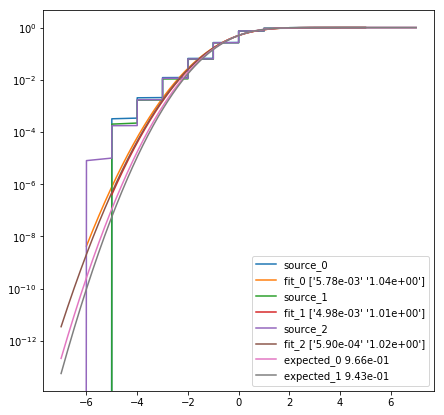

In [35]:
FitNormPrintExp([GroundTruthScore_para, tables_recon_para_score, tables_sim_para_score], [expected_norm, mean_norm])
#del GroundTruthTables_para, GroundTruthScore_para

In [67]:
tot_tables = GroundTruthTables.join(tables_recon, rsuffix='_recon').join(tables_sim, rsuffix='_treewas').dropna()

In [68]:
pval_cols = [col for col in tot_tables if 'pval' in col]

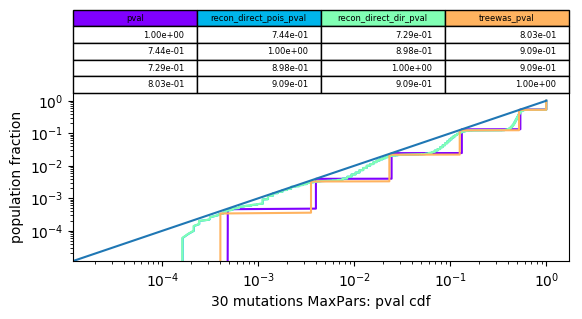

In [78]:
pval_hists(tot_tables, pval_cols, outpath=outpath)
# TODO fix hists

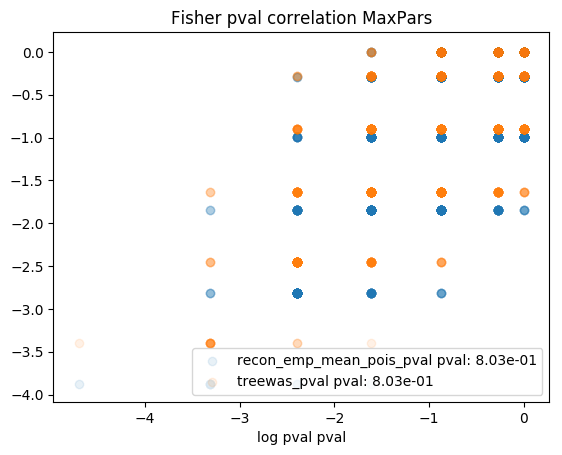

In [59]:
pval_corr(tot_tables, ['pval', 'recon_emp_mean_pois_pval', 'treewas_pval'], outpath=outpath)

In [ ]:
hist_to_spearman(tot_tables, pval_cols[0], pval_cols[1:], ReconHist, outpath=outpath)

In [ ]:
#ods_ratio_sf(tot_tables, ['ods', 'ods_para'], outpath=outpath)

In [79]:
tot_tables

,pval,score,score_recon,recon_direct_pois_pval,recon_direct_dir_pval,treewas_pval
0,0.537471,1.0,0,1.000000,1.000000,1.000000
1,1.000000,0.0,0,1.000000,1.000000,1.000000
2,0.537471,1.0,1,0.498127,0.498269,0.520611
3,0.537471,1.0,1,0.548493,0.548652,0.520611
4,0.537471,1.0,1,0.468270,0.468401,0.520611
5,1.000000,0.0,0,1.000000,1.000000,1.000000
6,0.537471,1.0,1,0.507333,0.507478,0.520611
7,0.537471,1.0,1,0.540861,0.541018,0.520611
8,1.000000,0.0,0,1.000000,1.000000,1.000000
9,1.000000,0.0,0,1.000000,1.000000,1.000000
